# Building confidence ellipses (in meters) for PyMC3 algorithm
### **Origin of the reference system: Projected 3D traveltime (Lower left corner)**

#### In the following code we will start building the confidence ellipses for our PyMC3 code. We only need the file **data/6_clusters/catalog_with_clusters_ids.csv** resulted from ConvNetQuake.

###### The *catalog_with_clusters_ids.csv* file is obtained afer run:
**./bin/preprocess/cluster_events.ridgcrest --src data/catalogs/Ridgecrest_filtrado.csv --dst data/6_clusters --n_components 6 --model KMeans**

In [1]:
#Importing libraries
import csv
import json
import os
import pandas as pd
from pyproj import Proj, transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

##### The original catalog is in decimal degrees (EPSG:4326). We need to transform this initial coordinate system to EPSG:32611, which is in meters and corresponds to the adequate projection system for our area of study. Moreover, it is neccessary to adjust the coordinate (0,0) to a relative reference system.

In [2]:
# Define the original coordinate system (latitude, longitude)
latlon_string = "+proj=latlong +datum=WGS84 +ellps=WGS84"
latlon = Proj(latlon_string)

# Define the target coordinate system (UTM in Zone 11, northern hemisphere, WGS84)
utm_string ="+proj=utm +zone=11 +datum=WGS84 +ellps=WGS84"
utm_s = Proj(utm_string)

# We need to transform the coordinates of the station as a special case (we will need to know for the plot)
station_latitude = 35.81574    # latitude of CI.CLC
station_longitude = -117.59751    #Longitude of CI.CLC

# If TravelTime 3D is chosen as (0,0): Coordinates of the reference point in the original system
#reference_latitude = 34.5    #3D Traveltime origin
#reference_longitude = -119.0    #3D Traveltime origin
reference_latitude = 35.2    #3D Traveltime origin projected
reference_longitude = -118.2    #3D Traveltime origin projected

# Transform coordinates of the station point to UTM in Zone 11, northern hemisphere, WGS84
station_x, station_y = transform(latlon, utm_s, station_longitude, station_latitude)
                         
# Transform coordinates of the reference point to UTM in Zone 11, northern hemisphere, WGS84
ref_x, ref_y = transform(latlon, utm_s, reference_longitude, reference_latitude)

# Read data from the CSV file
csv_file = '/Users/cecilia/CONVN/data/6_clusters/catalog_with_cluster_ids.csv'
data = pd.read_csv(csv_file)

# Transform all coordinates to the target coordinate system
data['longitude_UTM'], data['latitude_UTM'] = transform(latlon, utm_s, data['longitude'].values, data['latitude'].values)

# Subtract coordinates of the reference point to set it as the origin
data['longitude_UTM'] -= ref_x
data['latitude_UTM'] -= ref_y

# Subtract coordinates of the reference point to the station coordinates
station_x -= ref_x
station_y -= ref_y

# Print some rows of the resulting DataFrame
# print(data.head())

#Print the transformed station coordinates 
print(f'The transformed station coordinates are:{station_x}, {station_y}')

# Save the transformed data to a new CSV file
output_file = '/Users/cecilia/CONVN/data/6_clusters/catalog_with_cluster_ids_meters_2D_TT.csv'
data.to_csv(output_file, index=False)

# Define parameter for the .json file
projection_dict = {
    "latlon_string": latlon_string,
    "utm_string": utm_string,
    "Origin_reference": 'TT (lower left corner)',
    "ref_long": reference_longitude,
    "ref_lat": reference_latitude,
    "ref_x_UTM": ref_x,
    "ref_y_UTM": ref_y    
}

# Specify .json file's name
file_name = "/Users/cecilia/CONVN/data/6_clusters/csv_clusters/2D_TT/projections_catalog_2D_TT.json"

# Save the dictionary in a json file
with open(file_name, "w") as json_file:
    json.dump(projection_dict, json_file)


The transformed station coordinates are:55260.12018678372, 67794.21678934153


/var/folders/6p/x1tfp6451svc9hvzk2kt63wr0000h1/T/ipykernel_94672/2775903611.py:20: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  station_x, station_y = transform(latlon, utm_s, station_longitude, station_latitude)
/var/folders/6p/x1tfp6451svc9hvzk2kt63wr0000h1/T/ipykernel_94672/2775903611.py:23: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  ref_x, ref_y = transform(latlon, utm_s, reference_longitude, reference_latitude)
/var/folders/6p/x1tfp6451svc9hvzk2kt63wr0000h1/T/ipykernel_94672/2775903611.py:30: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  data['longitude_UTM'], data['latitude_UTM'] = transform(latlon, utm_s, data['longitude'].values, data['latitude'].values)


In [3]:
# Define the path of the .csv file
file_path = '/Users/cecilia/CONVN/data/6_clusters/catalog_with_cluster_ids_meters_2D_TT.csv'

# Create a dictionary to store data for each cluster_id
data_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

# Read the .csv file and split the data into the dictionary based on cluster_id
with open(file_path, 'r') as file:
    csv_reader = csv.reader(file)
    headers = next(csv_reader)  # Read the file header
    for row in csv_reader:
        cluster_id = int(row[2])
        data_dict[cluster_id].append(row)

# Create a directory to store the files
output_dir = '/Users/cecilia/CONVN/data/6_clusters/csv_clusters/2D_TT'
os.makedirs(output_dir, exist_ok=True)

# Write the data to separate files based on cluster_id
for cluster_id, rows in data_dict.items():
    cluster_file_path = os.path.join(output_dir, f'cluster_{cluster_id}_meters.csv')
    with open(cluster_file_path, 'w', newline='') as cluster_file:
        csv_writer = csv.writer(cluster_file)
        csv_writer.writerow(headers)  # Write the header
        csv_writer.writerows(rows)

print("Separate files created successfully.")


Separate files created successfully.


##### Next, we will build the confidence ellipses for each *cluster_id* and plot the ellipses.

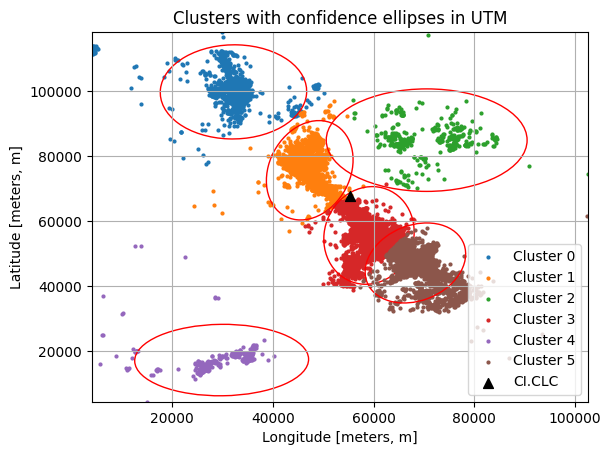

In [4]:
# Define a function to plot the confidence ellipse
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Calculate the angle of the ellipse
    theta = 0.5 * np.arctan(2 * pearson * cov[0, 1] / (cov[0, 0] - cov[1, 1]))
    # Calculate the axes of the ellipse
    width, height = 2 * n_std * np.sqrt(cov[0, 0]), 2 * n_std * np.sqrt(cov[1, 1])
    ellipse = Ellipse((np.mean(x), np.mean(y)), width, height, angle=180 * theta / np.pi, facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)
    return ellipse

# Create a figure and a single set of axes
fig, ax = plt.subplots()

# Define initial bounds
x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')

# Iterate over CSV files and display ellipses and points on the same figure
for i in range(6):
    # Read the CSV file
    data = pd.read_csv(f'/Users/cecilia/CONVN/data/6_clusters/csv_clusters/2D_TT/cluster_{i}_meters.csv')

    # Extract columns of longitude and latitude
    x = data['longitude_UTM']  # Make sure to put the correct column name
    y = data['latitude_UTM']  # Make sure to put the correct column name

    # Calculate mean and covariance matrix
    mu = np.mean(x), np.mean(y)
    cov = np.cov(x, y)

    # Plot data points and confidence ellipse on the same figure
    ax.scatter(x, y, s=4, label=f'Cluster {i}')
    confidence_ellipse(x, y, ax, edgecolor='red')

    # Update bounds
    x_min, x_max = min(x_min, min(x)), max(x_max, max(x))
    y_min, y_max = min(y_min, min(y)), max(y_max, max(y))

# Adjust axis bounds with a small margin
padding = 0.05
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

# Add station point (station_x, station_y)
ax.scatter(station_x, station_y, marker="^", color='black', s=50, label='CI.CLC')

# Uncomment if you want to plot event location results
#ax.scatter(5087.494, 5466.761, marker="s", color='black', s=40, label='Event A')
#ax.scatter(4529.634, 5011.558, marker="*", color='black', s=50, label='Event B')
#ax.scatter(5364.338, 4670.152, marker="X", color='black', s=50, label='Event C')

# Add labels to axes and title
ax.set_xlabel('Longitude [meters, m]')
ax.set_ylabel('Latitude [meters, m]')
ax.set_title('Clusters with confidence ellipses in UTM')

# Add legend in the lower-right corner and save the reference in a variable
legend = ax.legend(loc='lower right')

# Save the plot in PNG format and make sure the legend is included
plt.grid(True)
plt.savefig('/Users/cecilia/CONVN/data/6_clusters/confidence_ellipses_ridgecrest_meters_events_2D_TT.png', format='png', bbox_inches='tight', bbox_extra_artists=[legend])

# Show the figure
plt.show()


In [6]:
station_x

55260.12018678372

In [7]:
station_y

67794.21678934153

##### Finally we will obtain the confidence ellipses information.

In [5]:
# Lists to store covariance matrices and means
cov_matrices_2D_TT = []
mus_2D_TT = []

# Iterate over CSV files
for i in range(6):
    # Read the CSV file
    data = pd.read_csv(f'/Users/cecilia/CONVN/data/6_clusters/csv_clusters/2D_TT/cluster_{i}_meters.csv')

    # Extract columns of longitude and latitude
    x = data['longitude_UTM']
    y = data['latitude_UTM']

    # Calculate mean and covariance matrix
    mu = np.mean(x), np.mean(y)
    cov = np.cov(x, y)

    # Check if the covariance matrix is singular and, if necessary, regularize
    if np.linalg.det(cov) == 0:
        cov += 1e-10 * np.eye(2)  # Add a small amount to the diagonal to regularize

    # Append cov and mu to the lists
    cov_matrices_2D_TT.append(cov)
    mus_2D_TT.append(mu)

    # Calculate eigenvectors and eigenvalues
    eigvals, eigvecs = np.linalg.eig(cov)

    # Calculate orientation in degrees
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    theta = 0.5 * np.arctan(2 * pearson * cov[0, 1] / (cov[0, 0] - cov[1, 1]))
    orientation_degrees = 180 * theta / np.pi

    # Calculate standard deviations
    std_dev_x = np.sqrt(cov[0, 0])
    std_dev_y = np.sqrt(cov[1, 1])

    # Calculate 95% confidence ellipse
    confidence_level = 0.95
    rv = multivariate_normal(mean=mu, cov=cov)
    ell_radius_x = np.sqrt(-2 * np.log(1 - confidence_level)) * std_dev_x
    ell_radius_y = np.sqrt(-2 * np.log(1 - confidence_level)) * std_dev_y

    # Calculate eccentricity using Singular Value Decomposition (SVD)
    _, s, _ = np.linalg.svd(cov)
    eccentricity = np.sqrt(1 - (np.min(s) / np.max(s))**2)

    # In case of you need to print information
    print(f"\nCluster {i}:\n")
    print("Mean:", mu)
    print("Covariance matrix:\n", cov)
    #print("Eigenvalues:", eigvals)
    #print("Eigenvectors:\n", eigvecs)
    #print("Orientation (degrees):", orientation_degrees)
    #print("Standard deviation in x:", std_dev_x)
    #print("Standard deviation in y:", std_dev_y)
    #print(f"Ellipse radius at {confidence_level * 100}% confidence:")
    #print("In x:", ell_radius_x)
    #print("In y:", ell_radius_y)
    #print("Eccentricity:", eccentricity)
    #print("\n---\n")

    # Convert NumPy matrices to lists
    cov_matrices_2D_TT_list = cov.tolist()
    eigvals_2D_TT_list = eigvals.tolist()
    eigvecs_2D_TT_list = eigvecs.tolist()

    # Create dictionary
    dictionary = {
    "Mean": mu,
    "Covariance": cov_matrices_2D_TT_list,
    "Eigenvalues": eigvals_2D_TT_list,
    "Eigenvectors": eigvecs_2D_TT_list,
    "Orientation": orientation_degrees,
    "Standardx": std_dev_x,
    "Standardy": std_dev_y,
    "Inx": ell_radius_x,
    "Iny": ell_radius_y,
    "Eccentricity": eccentricity}

    # Specify the full path desired to save JSON files
    file_path= '/Users/cecilia/CONVN/data/6_clusters/csv_clusters/2D_TT/ellipse_parameters_2D_TT_'+str(i)
    
    # Save as JSON
    with open(file_path, 'w') as file:
        json.dump(dictionary, file, indent=4)


Cluster 0:

Mean: (32218.8764552767, 99838.81066135617)
Covariance matrix:
 [[23683434.08956666 -7482504.68269572]
 [-7482504.68269572 23076439.22744325]]

Cluster 1:

Mean: (47344.962152385786, 75701.25916421883)
Covariance matrix:
 [[ 7693426.86133857 -6823952.50352896]
 [-6823952.50352896 26516620.30147037]]

Cluster 2:

Mean: (70536.16173537279, 84978.75713692319)
Covariance matrix:
 [[44073456.563241    -268518.05843598]
 [ -268518.05843598 27670056.10147351]]

Cluster 3:

Mean: (59095.70339309293, 55637.688200668315)
Covariance matrix:
 [[ 8848368.20917511 -4026247.62006571]
 [-4026247.62006571 25189221.12884306]]

Cluster 4:

Mean: (29875.703410031598, 17266.873175985518)
Covariance matrix:
 [[33042473.58570345  3054639.48391083]
 [ 3054639.48391083 13434698.28908999]]

Cluster 5:

Mean: (68302.0192423577, 47165.003141898575)
Covariance matrix:
 [[ 9723465.07889593 -7677083.07661695]
 [-7677083.07661695 18175843.84263376]]
